# Workshop Notebook 2: Deploy Pipeline to Edge Devices

For this workshop, we will take a Wallaroo pipeline and publish it to an Open Container (OCI) Registry.  The registry details are stored in the Wallaroo instance as the Edge Registry.  

In this set of exercises, you will:

1. Use a pre-trained model and deploy it to Wallaroo.
1. Perform sample inferences.
1. Publish the pipeline to the Edge Registry.
1. See the steps to deploy the published pipeline to an Edge device and perform inferences through it.

Deployment to the Edge allows data scientists to work in Wallaroo to test their models in Wallaroo, then once satisfied with the results publish those pipelines.  DevOps engineers then take those published pipeline details from the Edge registry and deploy them into Docker and Kubernetes environments.

This workshop will demonstrate the following concepts:

* [Wallaroo Workspaces](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/):  Workspaces are environments were users upload models, create pipelines and other artifacts.  The workspace should be considered the fundamental area where work is done.  Workspaces are shared with other users to give them access to the same models, pipelines, etc.
* [Wallaroo Model Upload and Registration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/): ML Models are uploaded to Wallaroo through the SDK or the MLOps API to a **workspace**.  ML models include default runtimes (ONNX, Python Step, and TensorFlow) that are run directly through the Wallaroo engine, and containerized runtimes (Hugging Face, PyTorch, etc) that are run through in a container through the Wallaroo engine.
* [Wallaroo Pipelines](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/): Pipelines are used to deploy models for inferencing.  Each model is a **pipeline step** in a pipelines, where the inputs of the previous step are fed into the next.  Pipeline steps can be ML models, Python scripts, or Arbitrary Python (these contain necessary models and artifacts for running a model).
* [Pipeline Edge Publication](https://docs.wallaroo.ai/20230300/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/): How to publish a Wallaroo pipeline to an OCI registry, then deploy that pipeline into other environments.

For this tutorial, we will be providing pre-trained models in ONNX format, and have connected a sample Edge Registry to our Wallaroo instance.

For more Wallaroo procedures, see the [Wallaroo Documentation site](https://docs.wallaroo.ai).

## Preliminaries

In the blocks below we will preload some required libraries.

For convenience, the following `helper functions` are defined to retrieve previously created workspaces, models, and pipelines:

* `get_workspace(name, client)`: This takes in the name and the Wallaroo client being used in this session, and returns the workspace matching `name`.  If no workspaces are found matching the name, raises a `KeyError` and returns `None`.
* `get_model_version(model_name, workspace)`: Retrieves the most recent model version from the model matching the `model_name` within the provided `workspace`.  If no model matches that name, raises a `KeyError` and returns `None`.
* `get_pipeline(pipeline_name, workspace)`: Retrieves the most pipeline from the workspace matching the `pipeline_name` within the provided `workspace`.  If no model matches that name, raises a `KeyError` and returns `None`.

In [2]:
# preload needed libraries 

# Import Wallaroo Python SDK
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

# setting path - only needed when running this from the `with-code` folder.
import sys
sys.path.append('../')

from CVDemoUtils import CVDemo
from WallarooUtils import Util
cvDemo = CVDemo()
util = Util()

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)


In [3]:
## convenience functions from the previous notebooks

# return the workspace called <name> through the Wallaroo client.
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
            return workspace
    # if no workspaces were found
    if workspace==None:
        raise KeyError(f"Workspace {name} was not found.")
    return workspace


# returns the most recent model version in a workspace for the matching `model_name`
def get_model_version(model_name, workspace):
    modellist = workspace.models()
    model_version = [m.versions()[-1] for m in modellist if m.name() == model_name]
    # if no models match, return None
    if len(modellist) <= 0:
        raise KeyError(f"Model {mname} not found in this workspace")
        return None
    return model_version[0]

# get a pipeline by name in the workspace
def get_pipeline(pipeline_name, workspace):
    plist = workspace.pipelines()
    pipeline = [p for p in plist if p.name() == pipeline_name]
    if len(pipeline) <= 0:
        raise KeyError(f"Pipeline {pipeline_name} not found in this workspace")
        return None
    return pipeline[0]


### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [5]:
## blank space to log in 

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Set Configurations

Set the workspace, pipeline, and model used from Notebook 1.  The helper functions will make this task easier.

#### Set Configurations References

* [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)
* [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/)

In [7]:
# retrieve the previous workspace, model, and pipeline version

workspace_name = "workshop-workspace-cv-yolo-john"

workspace = get_workspace(workspace_name, wl)

# set your current workspace to the workspace that you just created
wl.set_current_workspace(workspace)

# optionally, examine your current workspace
wl.get_current_workspace()

model_name = 'yolov8n-tutorial'

prime_model_version = get_model_version(model_name, workspace)

pipeline_name = 'yolov8n-tutorial'

pipeline = get_pipeline(pipeline_name, workspace)

# display the workspace, pipeline and model version
display(workspace)
display(pipeline)
display(prime_model_version)


{'name': 'workshop-workspace-cv-yolo-john', 'id': 22, 'archived': False, 'created_by': 'b030ff9c-41eb-49b4-afdf-2ccbecb6be5d', 'created_at': '2023-10-12T18:06:31.490648+00:00', 'models': [{'name': 'yolov8n-tutorial', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2023, 10, 12, 18, 8, 0, 428215, tzinfo=tzutc()), 'created_at': datetime.datetime(2023, 10, 12, 18, 8, 0, 428215, tzinfo=tzutc())}], 'pipelines': [{'name': 'yolov8n-tutorial', 'create_time': datetime.datetime(2023, 10, 12, 18, 8, 2, 515256, tzinfo=tzutc()), 'definition': '[]'}]}

name,yolov8n-tutorial
created,2023-10-12 18:08:02.515256+00:00
last_updated,2023-10-12 18:08:05.818332+00:00
deployed,False
tags,
versions,"170d0db0-69b2-4fd2-a196-7922c6987f98, d3b3bf84-e585-441d-a7f1-de5cb84c2ab7"
steps,yolov8n-tutorial
published,False


Name,yolov8n-tutorial
Version,acaa05a8-7cce-4c73-b433-0029f06ccc9b
File Name,yolov8n.onnx
SHA,3ed5cd199e0e6e419bd3d474cf74f2e378aacbf586e40f24d1f8c89c2c476a08
Status,ready
Image Path,None
Updated At,2023-12-Oct 18:08:00


## Deploy the Pipeline with the Model Version Step

As per the other workshops:

1. Clear the pipeline of all steps.
1. Add the model version as a pipeline step.
1. Deploy the pipeline with the following deployment configuration:

```python
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()
```

In [8]:
pipeline.clear()
pipeline.add_model_step(prime_model_version)

deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()
pipeline.deploy(deployment_config=deploy_config)

name,yolov8n-tutorial
created,2023-10-12 18:08:02.515256+00:00
last_updated,2023-10-12 18:15:39.394422+00:00
deployed,True
tags,
versions,"7365a4cc-a8da-4739-ba6a-c99089fc2e15, 170d0db0-69b2-4fd2-a196-7922c6987f98, d3b3bf84-e585-441d-a7f1-de5cb84c2ab7"
steps,yolov8n-tutorial
published,False


### Sample Inference

Verify the pipeline is deployed properly with a sample inference with the file `./data/test_table.arrow`.

  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.16% | Class: Car | Bounding Box: [390, 85, 186, 108]


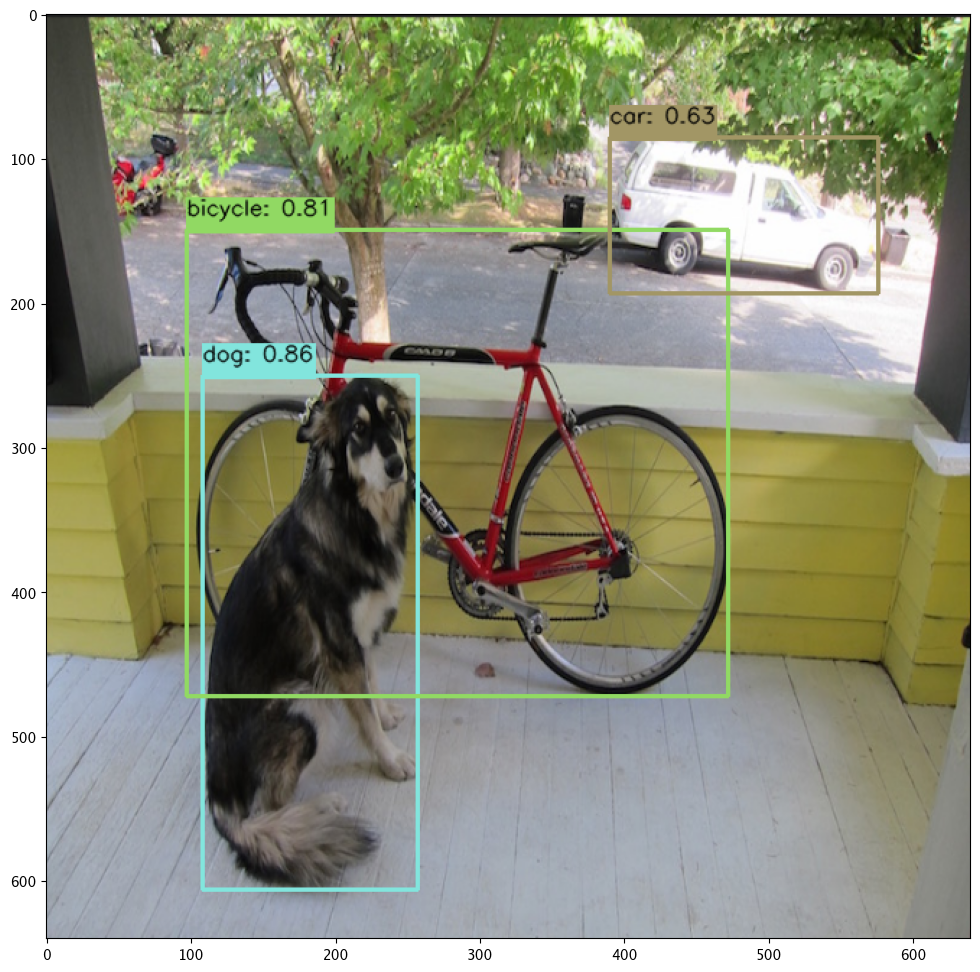

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 34,  34,  34],
        ...,
        [ 34,  34,  34],
        [ 33,  33,  33],
        [ 34,  34,  34]],

       [[ 53,  54,  48],
        [ 54,  55,  49],
        [ 54,  55,  49],
        ...,
        [153, 178, 111],
        [151, 183, 108],
        [159, 176,  99]],

       ...,

       [[159, 167, 178],
        [159, 165, 177],
        [158, 163, 175],
        ...,
        [126, 127, 121],
        [127, 125, 120],
        [128, 120, 117]],

       [[160, 168, 179],
        [156, 162, 174],
        [152, 157, 169],
        ...,
        [126, 127, 121],
        [129, 127, 122],
        [127, 118, 116]],

       [[155, 163, 174],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [10]:
# sample inference from previous code here

##  blank space to create test data, and send some data to your model

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('../data/dogbike.png', width, height)
tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1, 'tensor')


results = pipeline.infer(df)

# display the converted image and bounding boxes

confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(results, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

## Undeploying Your Pipeline

You should always undeploy your pipelines when you are done with them, or don't need them for a while. This releases the resources that the pipeline is using for other processes to use. You can always redeploy the pipeline when you need it again. As a reminder, here are the commands to deploy and undeploy a pipeline:

```python

# "turn off" the pipeline and releaase its resources
my_pipeline.undeploy()
```

In [11]:
# blank space to undeploy the pipeline
pipeline.undeploy()

name,yolov8n-tutorial
created,2023-10-12 18:08:02.515256+00:00
last_updated,2023-10-12 18:15:39.394422+00:00
deployed,False
tags,
versions,"7365a4cc-a8da-4739-ba6a-c99089fc2e15, 170d0db0-69b2-4fd2-a196-7922c6987f98, d3b3bf84-e585-441d-a7f1-de5cb84c2ab7"
steps,yolov8n-tutorial
published,False


## Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)` which has the following parameters and returns.

#### Publish a Pipeline Parameters

The `publish` method takes the following parameters.  The containerized pipeline will be pushed to the Edge registry service with the model, pipeline configurations, and other artifacts needed to deploy the pipeline.

| Parameter | Type | Description |
|---|---|---|
| `deployment_config` | `wallaroo.deployment_config.DeploymentConfig` (*Optional*) | Sets the pipeline deployment configuration.  For example:    For more information on pipeline deployment configuration, see the [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration]({{<ref "wallaroo-sdk-essentials-pipeline-deployment-config">}}).

#### Publish a Pipeline Returns

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline version id | integer | Numerical Wallaroo id of the pipeline version published. |
| status | string | The status of the pipeline publication.  Values include:  <ul><li>PendingPublish: The pipeline publication is about to be uploaded or is in the process of being uploaded.</li><li>Published:  The pipeline is published and ready for use.</li></ul> |
| Engine URL | string | The URL of the published pipeline engine in the edge registry. |
| Pipeline URL | string | The URL of the published pipeline in the edge registry. |
| Helm Chart URL | string | The URL of the helm chart for the published pipeline in the edge registry. |
| Helm Chart Reference | string | The help chart reference. |
| Helm Chart Version | string | The version of the Helm Chart of the published pipeline.  This is also used as the Docker tag. |
| Engine Config | `wallaroo.deployment_config.DeploymentConfig` | The pipeline configuration included with the published pipeline. |
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### Publish the Pipeline for Edge Deployment Exercise

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command.  `deployment_config` is an optional field that specifies the pipeline deployment.  This can be overridden by the DevOps engineer during deployment.

In this example, assuming that the pipeline was saved to the variable `my_pipeline`, we would publish it to the Edge Registry already stored in the Wallaroo instance and store the pipeline publish to the variable `my_pub` with the following command:

```python
my_pub=pipeline.publish(deploy_config)
# display the publish
my_pub
```


In [12]:
## blank space to publish the pipeline

my_pub=pipeline.publish(deploy_config)
# display the publish
my_pub


Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing...Published.


ID,15
Pipeline Version,5b5da2b2-e2b3-457d-89d3-a9333cf2f164
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.3.0-3854
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/yolov8n-tutorial:5b5da2b2-e2b3-457d-89d3-a9333cf2f164
Helm Chart URL,ghcr.io/wallaroolabs/doc-samples/charts/yolov8n-tutorial
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:dd28c99b9f88655d770687eb0380f88b9567549082f4fe0c1ef95d40ea77abb9
Helm Chart Version,0.0.1-5b5da2b2-e2b3-457d-89d3-a9333cf2f164
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}, 'engineAux': {'images': {}}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


## List Published Pipelines

The method `wallaroo.client.list_pipelines()` shows a list of all pipelines in the Wallaroo instance, and includes the `published` field that indicates whether the pipeline was published to the registry (`True`), or has not yet been published (`False`).

### List Published Pipelines Exercise

List all pipelines and see which ones are published or not.  For example, if your client was saved to the variable `wl`, then the following will list the pipelines and display which ones are published.

```python
wl.list_pipelines()
```

In [13]:
# list the pipelines and view which are published

wl.list_pipelines()

name,created,last_updated,deployed,tags,versions,steps,published
yolov8n-tutorial,2023-12-Oct 18:08:02,2023-12-Oct 18:17:04,False,,"5b5da2b2-e2b3-457d-89d3-a9333cf2f164, 7365a4cc-a8da-4739-ba6a-c99089fc2e15, 170d0db0-69b2-4fd2-a196-7922c6987f98, d3b3bf84-e585-441d-a7f1-de5cb84c2ab7",yolov8n-tutorial,True
cv-yolo8,2023-12-Oct 17:42:19,2023-12-Oct 17:52:53,False,,"2779aa39-537b-4a8c-bc56-46cd988b385b, 2f35c7c0-4b9a-4d43-bd8f-3abef037f7a7, 89b89fbd-bdef-4281-b3da-99cea6877ef5, 2b9f6b92-502a-42e2-b28e-4d4397487b56, 60ec6b70-17dd-4e50-8a0e-a1b5f4bcc301",yolov8n-tutorial,False
cv-yolo8,2023-12-Oct 17:08:10,2023-12-Oct 17:28:04,True,,"c9445821-06da-425d-830d-3c18b5bb5bc4, 50ae25fd-0a04-40ae-9d28-e88d4789ffa2, f6b82546-bfb9-4083-a981-144b512a377f, 72ab72ee-f08c-401e-ae94-5e4d59e58237",yolov8n-tutorial,False
cv-yolo8,2023-12-Oct 16:46:11,2023-12-Oct 16:58:42,False,,"1c9d0733-38e9-49c4-9f81-2b98395fc121, 7a18da43-e34c-4908-afda-75fe8aa4baf0, 5c2712ce-ad5c-4048-9ab5-6008472d5868",yolov8n-tutorial,False
yolo8demonstration,2023-11-Oct 15:06:07,2023-11-Oct 18:29:33,False,,"4f05b506-2584-4eda-8c8d-54e6534b4bfb, b7749a4f-1e62-47a0-8d4b-01c3dac414cb, 40c2402a-bb03-4cf4-b4be-dd009fc28a97, 283d1262-f1a8-49f3-b350-f83754272fac, 995df27c-33bb-48eb-9a6c-4eed1ca90a2d, af4af589-1805-4404-91f8-194308c166a0, e8e7f7bb-6502-487a-8afe-2bdc2b7566b1, 01e0ac28-5040-4ee5-90cf-069abb46d06b",yolov8n,True
yolo8demonstration,2023-11-Oct 14:37:32,2023-11-Oct 15:03:11,False,,"b3bb9d2b-a41c-4ad4-9627-6e550ec70eea, 31eb1f8f-8c8e-4f4c-acf8-8930e95f81b0, 90d31341-fcae-4c6f-b03e-b506bf979c67, 2a3933c4-52db-40c6-b80f-9031664fd08a, 95bbabf1-1f15-4e4b-9e67-f7730c2b2cbd, 6c672144-ed4f-4505-97eb-a5b1763af847, 7149e0bc-089b-4d57-9a0b-5d4f4a9a4097, 329e394b-5105-4dc3-b0ff-5411623fc139, 7acaea4e-6ae3-426b-9f97-5e3dcc39c48e, a8b2c009-e7b5-4b96-81b9-40447797a05f, 09952a45-2401-4ebd-8e85-c678365b64a7, d870a558-10ef-448e-b00d-068c10c7e82b, fa531e16-1706-43c4-98d9-e0dd6355fe6f, 4c0b535e-b39b-40f4-82a7-34965b2f7c2a, 3507964d-382f-4e1c-84c7-64c5e27f819c, 9971f8dd-a17b-4d6a-ab72-d786d4990fab, b92a035f-903c-4039-8303-8ceb979a53c2",yolov8n,True
edge-cv-demo,2023-10-Oct 16:52:02,2023-10-Oct 16:53:08,False,,"4f116503-6506-47d6-b427-1e7056a8c62e, a91a8b17-f587-439f-9001-292892e94336, 5320bc9c-e64f-4bc1-ac97-7d2b40eeb53e",resnet-50,True
edge04yolo8n,2023-10-Oct 14:48:43,2023-10-Oct 16:35:13,False,,"9b40cc1b-af1c-4521-9354-4e33e4f9d9c5, b742ddbf-2c69-4c70-b59e-bb33a6f7979c, bab6e409-af82-4678-8ba7-0f0e49997529, 4812d72c-a0ca-4432-aa6d-8a12d9a7fd02",yolov8n,False
edge-pipeline-classification-cybersecurity,2023-10-Oct 14:36:15,2023-10-Oct 14:37:08,False,,"fe99cad9-dc32-4846-bcbc-27de68975784, b53618b7-191e-44cb-b38d-bbfd9ffc7748, e1a9f56c-17f5-45f8-86bf-69ebf6c446aa",aloha,True
hf-summarizer,2023-05-Oct 16:31:44,2023-05-Oct 20:24:57,False,,"6c591132-5ba7-413d-87a6-f4221ef972a6, 60bb46b0-52b8-464a-a379-299db4ea26c0, c4c1213a-6b6e-4a98-b397-c7903e8faae4, 25ef3557-d73b-4e8b-874e-1e126693eff8, cc4bd9e0-b661-48c9-a0a9-29dafddeedcb, d359aafc-843d-4e32-9439-e365b8095d65, 8bd92035-2894-4fe4-8112-f5f3512dc8ea",hf-summarizer,True


## List Publishes from a Pipeline

All publishes created from a pipeline are displayed with the `wallaroo.pipeline.publishes` method.  The `pipeline_version_id` is used to know what version of the pipeline was used in that specific publish.  This allows for pipelines to be updated over time, and newer versions to be sent and tracked to the Edge Deployment Registry service.

### List Publishes Parameters

N/A

### List Publishes Returns

A List of the following fields:

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline_version_id | integer | Numerical Wallaroo id of the pipeline version published. |
| engine_url | string | The URL of the published pipeline engine in the edge registry. |
| pipeline_url | string | The URL of the published pipeline in the edge registry. |
| created_by | string | The email address of the user that published the pipeline.
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### List Publishes from a Pipeline Exercise

List all of the publishes from our pipeline.  For example, if our pipeline is `my_pipeline`, then we would list all publishes from the pipeline with the following:

```python
my_pipeline.publishes()
```

In [14]:
pipeline.publishes()

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
15,5b5da2b2-e2b3-457d-89d3-a9333cf2f164,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.3.0-3854,ghcr.io/wallaroolabs/doc-samples/pipelines/yolov8n-tutorial:5b5da2b2-e2b3-457d-89d3-a9333cf2f164,john.hummel@wallaroo.ai,2023-12-Oct 18:17:05,2023-12-Oct 18:17:05


## Congratulations!

You have now 

* Created a workspace and set it as the current workspace.
* Uploaded an ONNX model.
* Created a Wallaroo pipeline, and set the most recent version of the uploaded model as a pipeline step.
* Successfully send data to your pipeline for inference through the SDK and through an API call.


## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.

### Docker Deployment

First, the DevOps engineer must authenticate to the same OCI Registry service used for the Wallaroo Edge Deployment registry.

For more details, check with the documentation on your artifact service.  The following are provided for the three major cloud services:

* [Set up authentication for Docker](https://cloud.google.com/artifact-registry/docs/docker/authentication)
* [Authenticate with an Azure container registry](https://learn.microsoft.com/en-us/azure/container-registry/container-registry-authentication?tabs=azure-cli)
* [Authenticating Amazon ECR Repositories for Docker CLI with Credential Helper](https://aws.amazon.com/blogs/compute/authenticating-amazon-ecr-repositories-for-docker-cli-with-credential-helper/)

For the deployment, the engine URL is specified with the following environmental variables:

```bash
{published engine url}
-e DEBUG=true -e OCI_REGISTRY={your registry server} \
-e CONFIG_CPUS=4 \ # optional number of CPUs to use
-e OCI_USERNAME={registry username} \
-e OCI_PASSWORD={registry token here} \
-e PIPELINE_URL={published pipeline url}
```

#### Docker Deployment Example

Using our sample environment, here's sample deployment using Docker with a computer vision ML model, the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```bash
docker run -p 8080:8080 \
    -e DEBUG=true -e OCI_REGISTRY={your registry server} \
    -e CONFIG_CPUS=4 \
    -e OCI_USERNAME=oauth2accesstoken \
    -e OCI_PASSWORD={registry token here} \
    -e PIPELINE_URL={your registry server}/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555 \
    {your registry server}/engine:v2023.3.0-main-3707
```

### Docker Compose Deployment

For users who prefer to use `docker compose`, the following sample `compose.yaml` file is used to launch the Wallaroo Edge pipeline.  This is the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```yml
services:
  engine:
    image: {Your Engine URL}
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: {Your Pipeline URL}
      OCI_REGISTRY: {Your Edge Registry URL}
      OCI_USERNAME:  {Your Registry Username}
      OCI_PASSWORD: {Your Token or Password}
      CONFIG_CPUS: 4
```

For example:

```yml
services:
  engine:
    image: sample-registry.com/engine:v2023.3.0-main-3707
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
      OCI_REGISTRY: sample-registry.com
      OCI_USERNAME:  _json_key_base64
      OCI_PASSWORD: abc123
      CONFIG_CPUS: 4
```

#### Docker Compose Deployment Example

The deployment and undeployment is then just a simple `docker compose up` and `docker compose down`.  The following shows an example of deploying the Wallaroo edge pipeline using `docker compose`.

```bash
docker compose up
[+] Running 1/1
 ✔ Container cv_data-engine-1  Recreated                                                                                                                                                                 0.5s
Attaching to cv_data-engine-1
cv_data-engine-1  | Wallaroo Engine - Standalone mode
cv_data-engine-1  | Login Succeeded
cv_data-engine-1  | Fetching manifest and config for pipeline: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
cv_data-engine-1  | Fetching model layers
cv_data-engine-1  | digest: sha256:c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   filename: c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   name: resnet-50
cv_data-engine-1  |   type: model
cv_data-engine-1  |   runtime: onnx
cv_data-engine-1  |   version: 693e19b5-0dc7-4afb-9922-e3f7feefe66d
cv_data-engine-1  |
cv_data-engine-1  | Fetched
cv_data-engine-1  | Starting engine
cv_data-engine-1  | Looking for preexisting `yaml` files in //modelconfigs
cv_data-engine-1  | Looking for preexisting `yaml` files in //pipelines
```

### Helm Deployment

Published pipelines can be deployed through the use of helm charts.

Helm deployments take up to two steps - the first step is in retrieving the required `values.yaml` and making updates to override.

1. Pull the helm charts from the published pipeline.  The two fields are the Helm Chart URL and the Helm Chart version to specify the OCI .    This typically takes the format of:

  ```bash
  helm pull oci://{published.helm_chart_url} --version {published.helm_chart_version}
  ```

1. Extract the `tgz` file and copy the `values.yaml` and copy the values used to edit engine allocations, etc.  The following are **required** for the deployment to run:

  ```yml
  ociRegistry:
    registry: {your registry service}
    username:  {registry username here}
    password: {registry token here}
  ```

  Store this into another file, suc as `local-values.yaml`.

1. Create the namespace to deploy the pipeline to.  For example, the namespace `wallaroo-edge-pipeline` would be:

  ```bash
  kubectl create -n wallaroo-edge-pipeline
  ```

1. Deploy the `helm` installation with `helm install` through one of the following options:
    1. Specify the `tgz` file that was downloaded and the local values file.  For example:

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {tgz path}
        ```

    1. Specify the expended directory from the downloaded `tgz` file.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {helm directory path}
        ```

    1. Specify the Helm Pipeline Helm Chart and the Pipeline Helm Version.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} oci://{published.helm_chart_url} --version {published.helm_chart_version}
        ```

1. Once deployed, the DevOps engineer will have to forward the appropriate ports to the `svc/engine-svc` service in the specific pipeline.  For example, using `kubectl port-forward` to the namespace `ccfraud` that would be:

    ```bash
    kubectl port-forward svc/engine-svc -n ccfraud01 8080 --address 0.0.0.0`
    ```

The following code segment generates a `docker run` template based on the previously published pipeline, assuming our publish was listed as `my_pub`.

In [15]:
docker_deploy = f'''
docker run -p 8080:8080 \\
    -e DEBUG=true -e OCI_REGISTRY=$REGISTRYURL \\
    -e CONFIG_CPUS=4 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={my_pub.pipeline_url} \\
    {my_pub.engine_url}
'''

print(docker_deploy)


docker run -p 8080:8080 \
    -e DEBUG=true -e OCI_REGISTRY=$REGISTRYURL \
    -e CONFIG_CPUS=4 \
    -e OCI_USERNAME=$REGISTRYUSERNAME \
    -e OCI_PASSWORD=$REGISTRYPASSWORD \
    -e PIPELINE_URL=ghcr.io/wallaroolabs/doc-samples/pipelines/yolov8n-tutorial:5b5da2b2-e2b3-457d-89d3-a9333cf2f164 \
    ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.3.0-3854



### Docker Compose Deployment Exercise

Use the `docker compose up` command on your own `compose.yaml` using the sample above, replacing the `OCI_USERNAME` and `OCI_PASSWORD` with the values provided by your instructor.

## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

### Pipelines Endpoints

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

For this example, the deployment is made on a machine called `testboy.local`.  Replace this URL with the URL of you edge deployment.

#### Pipelines Endpoints Exercise

Use the following `curl` command to view the pipeline data.  For example, if the pipeline was deployed on `localhost`, then the command would be:

```bash
!curl locahost:8080/pipelines
```

In [17]:
# blank space to run the command - replace testboy.local with the host

!curl localhost:8080/pipelines

{"pipelines":[{"id":"yolov8n-tutorial","status":"Running"}]}

### Models Endpoints

The endpoint `/models` returns a List of models with the following fields:

* **name** (*String*): The model name.
* **sha** (*String*): The sha hash value of the ML model.
* **status** (*String*):  The status of either Running or Error if there are any issues.
* **version** (*String*):  The model version.  This matches the version designation used by Wallaroo to track model versions in UUID format.

#### Models Endpoints Exercise

Use the following `curl` command to view the models data.  For example, if the pipeline was deployed on `localhost`, then the command would be:

```bash
!curl locahost:8080/models
```

In [18]:
# blank space to run the command - replace testboy.local with the host

!curl localhost:8080/models

{"models":[{"name":"yolov8n-tutorial","sha":"3ed5cd199e0e6e419bd3d474cf74f2e378aacbf586e40f24d1f8c89c2c476a08","status":"Running","version":"acaa05a8-7cce-4c73-b433-0029f06ccc9b"}]}

### Edge Deployed Inference

The inference endpoint takes the following pattern:

* `/pipelines/{pipeline-name}`:  The `pipeline-name` is the same as returned from the [`/pipelines`](#list-pipelines) endpoint as `id`.

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.

It returns a `application/json; format=pandas-records` - the same pandas record we've been working with.

### Edge Deployed Inference Exercise

Perform an inference on the deployed pipeline using `curl`.  This command will look like this:

```bash
!curl -X POST localhost:8080/pipelines/{YOUR PIPELINE NAME} -H "Content-Type: application/json; format=pandas-records" --data @../data/singleton.df.json
```

In [20]:
!curl -X POST localhost:8080/pipelines/yolov8n-tutorial \
    -H "Content-Type:application/json; format=pandas-records" \
    --data-binary @../data/dogbike.df.json > edge.df.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.7M  100 13.6M  100 15.0M   9.9M  11.0M  0:00:01  0:00:01 --:--:-- 21.0M
